# Computing the core Čech filtration for a fixed $k$

In this notebook, we show how to compute the persistent homology of the core Čech filtration in the simplest case where $k$ is fixed. For $k=1$ we demonstrate that the core Čech filtration is indeed equivalent to the usual Čech filtration by comparing it to the $\alpha$-complex. Furthermore, we compute the persistent homology of a noisy circle for different values of $k$ using the core Čech filtration.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext line_profiler
# %load_ext cython

In [3]:
import math
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from miniball import Miniball
from scipy.spatial import KDTree

from datasets_morten import sample_circle, sample_rectangle, sample_torus, sample_cube, sample_flat_torus
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [4]:
from datasets_morten import sample_sphere

In [5]:
rng = np.random.default_rng(seed=0)

### Compute distances to k-nearest neighbors in X

In [6]:
def k_nearest_neighbor_distances(X, k):
    kd_tree = KDTree(X)
    k_core_distances, _ = kd_tree.query(X, k=k, workers=-1)
    return k_core_distances  

### Compute filtration values of faces from squared radius and core values

In [7]:
def core_value(face, squared_radius, core_values):
    max_core = max(core_values[face]) 
    return max(squared_radius ** 0.5, max_core)

### Compute core value for each points

In [8]:
def vertex_values(X, max_k, max_r):
    if max_r is None or max_k <= 1:
        return k_nearest_neighbor_distances(X, k=[max_k])
    k_core_distances = k_nearest_neighbor_distances(X, np.arange(1, max_k + 1))
    line = np.linspace(max_r, 0, num=max_k)
    if max_k>1:
        indices = np.argmax(line <= k_core_distances, axis=1)
        values = k_core_distances[np.arange(len(k_core_distances)), indices]
        values[values > max_r] = max_r
    else:
        values = np.array(k_core_distances)
    return values

### Compute core simplex tree from a simplex tree filtered by squared radius and a point cloud

In [9]:
def core_complex(X, st, max_k, max_r=None):
    k_core_distances = vertex_values(X, max_k, max_r)**2
    for vertex in range(X.shape[0]):
        st.assign_filtration([vertex], k_core_distances[vertex])
    st.make_filtration_non_decreasing()
    return st

### Compute simplex tree of a point cloud filtered by squared radius

In [10]:
def cech_squared_radius(X, max_dim=1):
    st = gudhi.SimplexTree()
    for dim in range(max_dim+1):
        for face in combinations(range(len(X)),dim+1):
            val = Miniball(X[list(face)]).squared_radius()
            st.insert(face, val)
    return st

### Construct core cech simplex tree

In [11]:
def core_cech(X, max_k=10, max_r=None, max_dim=1):
    st = cech_squared_radius(X, max_dim=max_dim)
    return core_complex(X, st, max_k, max_r)

### Construct core alpha simplex tree

In [12]:
def core_alpha(X, max_k=10, max_r=None, precision='safe'):
    st = gudhi.AlphaComplex(points=X, precision=precision).create_simplex_tree()
    return core_complex(X, st, max_k, max_r)

In [13]:
def sqrt_persistence(st):
    persistence = st.persistence()
    return [(dim, (birth**.5, death**.5)) for dim, (birth, death) in persistence]

In [14]:
def plot_sqrt_persistence(st, axes=None):
    return gudhi.plot_persistence_diagram(sqrt_persistence(st), axes=axes)

In [15]:
def persistence_intervals_in_dimension(persistence, dim):
    return np.array([(b, d) for dimension, (b, d) in persistence if dimension == dim])    

In [16]:
def persistence_diagrams(
    X, max_ks: list[int] = [1, 10, 100, 1000], 
    max_r: float | None = None
) -> list[tuple[int, tuple[int, int]]]:
    res = []
    for i, max_k in enumerate(max_ks):
        st = core_alpha(X, max_k=max_k, max_r=max_r)
        persistence = sqrt_persistence(st)
        res.append(persistence)
    return res

In [17]:
def bottleneck_distances(pers1, pers2, dim):
    n = len(pers1)
    m = len(pers2)
    A = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            a = persistence_intervals_in_dimension(pers1[i], dim)
            b = persistence_intervals_in_dimension(pers2[j], dim)
            bdist = gudhi.bottleneck_distance(a, b)
            A[i, j] = bdist
    return A

In [18]:
def plot_persistence_diagrams(pers_diagrams, max_ks, max_r, title="Alpha Čech"):
    fig, axs = plt.subplots(ncols=len(max_ks), figsize=(14, 14 / len(max_ks)))
    fig.suptitle(title)
    for i, (pers, max_k) in enumerate(zip(pers_diagrams, max_ks)):
        gudhi.plot_persistence_diagram(pers, axes=axs[i])
        # st_core = core_cech(X, max_dim=2, max_k=max_k, max_r=max_r)
        # plot_sqrt_persistence(st_core, axes=axs[i])
        # gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
        axs[i].set_title(f"max_k={max_k}, max_r={max_r:.2f}")
    fig.tight_layout()
    return fig    

In [61]:
N = 20000
M = 2000
sigma = 0.07

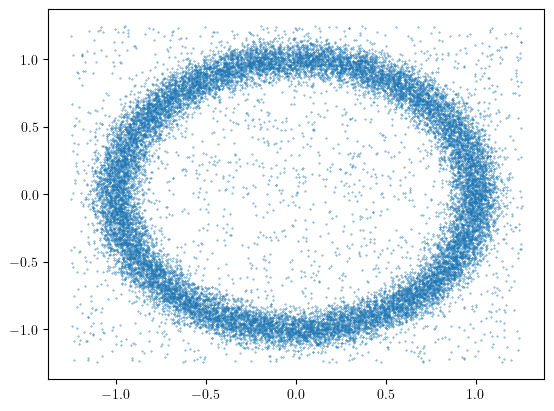

In [62]:
Z = sample_circle(N, rng, std=sigma)
upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(M, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
X = np.r_[Z, Y]
plt.scatter(*X.T, s=0.1)
plt.show()

In [63]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (1, (0, 1))]]

CPU times: user 3.38 s, sys: 51.6 ms, total: 3.43 s
Wall time: 1.93 s


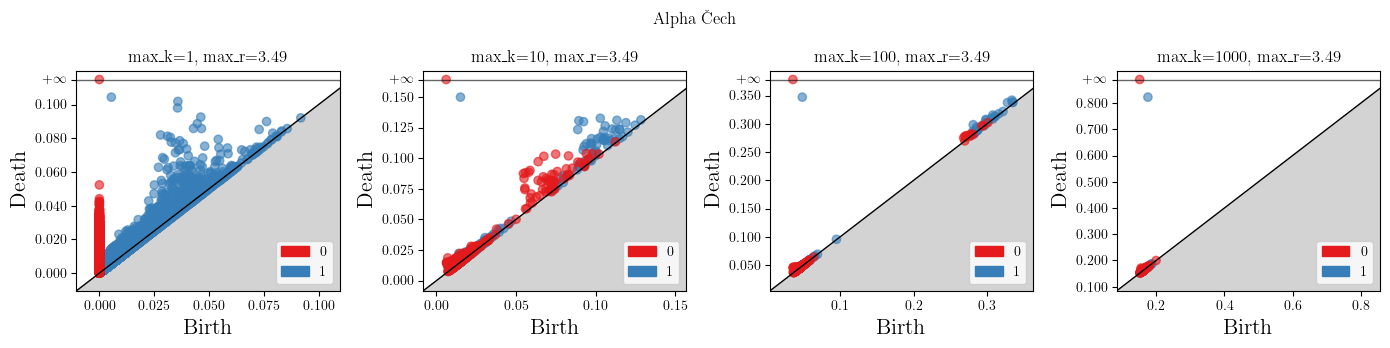

In [64]:
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [65]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([[0.5       , 0.5       , 0.5       , 0.17711019]])

In [66]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([[0.02616605, 0.01705111, 0.0355741 , 0.15172155]])

### Two circles with noise

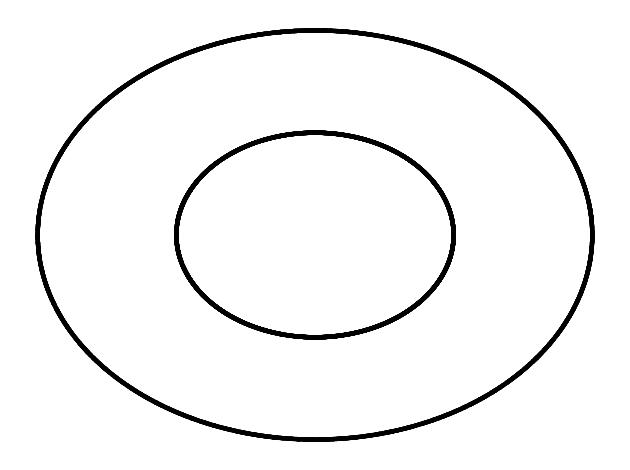

In [73]:
N1 = N // 2
N2 = N // 2
M = 10_000

Z1 = sample_circle(N1, rng, r=1, std=sigma)
Z2 = sample_circle(N2, rng, r=0.5, std=sigma)
# Z3 = sample_circle(N3, rng, r=0.2, std=0.02)
Z = np.r_[Z1, Z2]

upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(M, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
# Y = sample_rectangle(M, rng)
X = np.r_[Z1, Z2, Y]
plt.scatter(*X.T, s=10, color="black", alpha=0.5, edgecolor="none")
plt.gca().axis("off")
plt.tight_layout()
plt.show()

In [79]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (0, (0, 0.25)), (1, (0, 0.25)), (1, (0, 0.5))]]
# + pers_diagrams

CPU times: user 3.45 s, sys: 62.9 ms, total: 3.52 s
Wall time: 2.39 s


CPU times: user 496 ms, sys: 139 ms, total: 635 ms
Wall time: 413 ms


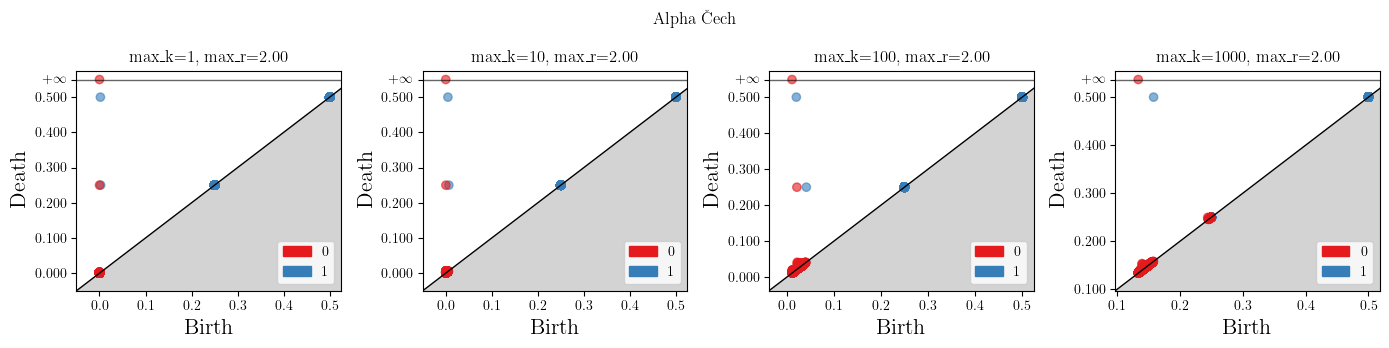

In [80]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [81]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([[0.00252043, 0.00697009, 0.04183918, 0.15836759]])

In [82]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([[0.00125573, 0.00294729, 0.02175787, 0.13400472]])

## Torus with noise

In [ ]:
N = 40_000
M = 15_000

Z = sample_torus(N, rng, std=0.02)
Y = sample_cube(M, rng, lower_left_corner=(-2, -2, -0.5), upper_right_corner=(2, 2, 0.5))
X = np.r_[Z, Y]

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*X.T, alpha=0.2, color="black", s=5, edgecolor="none")
ax.set_aspect("equal")
ax.axis("off")
plt.show()

In [ ]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (1, (0, 0.25)), (1, (0, 0.5)), (2, (0, 0.25))]]
# + pers_diagrams

In [ ]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=2)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

In [ ]:
N = 50_000
M = 5_000

Z = sample_sphere(N, rng, std=0.1)
Y = sample_cube(M, rng, lower_left_corner=(-1, -1, -1), upper_right_corner=(1, 1, 1))
X = np.r_[Z, Y]

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*X.T, alpha=0.2, color="black", s=5, edgecolor="none")
ax.set_aspect("equal")
ax.axis("off")
plt.show()

In [ ]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (2, (0, 1.))]]
# + pers_diagrams

In [ ]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=2)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

In [ ]:
N = 50_000
M = 5_000
Z = sample_flat_torus(N, rng, std=0.02)
Y = sample_cube(M, rng, lower_left_corner=(-1, -1, -1, -1), upper_right_corner=(1, 1, 1, 1))
X = np.r_[Z, Y]

In [ ]:
%%time
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (1, (0, 1.)), (1, (0,1.)), (2, (0, 1.))]]
# + pers_diagrams

In [ ]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=2)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)